# Final challenge: Solving the Gross-Pitaevskii Equation

Author(s): Kyle Godbey, Pablo Giuliani

Maintainer: Kyle Godbey

Parts adapted from [this paper](https://arxiv.org/pdf/2203.05284.pdf) with permission from the authors.

## Background

The [Gross](https://link.springer.com/article/10.1007/BF02731494)-[Pitaevskii](http://jetp.ras.ru/cgi-bin/dn/e_013_02_0451.pdf) (GP) equation (also see [here](https://epubs.siam.org/doi/10.1137/20M1313106) for a RBM application) is a nonlinear Schrödinger equation that approximately describes the low-energy properties of dilute Bose-Einstein condensates. Using a self-consistent mean field approximation, the many-body wavefunction is reduced to a description in terms of a single complex-valued wavefunction $\phi(\vec{r})$. We work with the [one-dimensional Gross-Pitaevskii equation](https://journals.aps.org/pra/abstract/10.1103/PhysRevA.62.063610) with a harmonic trapping potential by letting $F_\alpha$ be:

\begin{equation}
  F_{q,\kappa}(\phi)= -\phi''+\kappa x^2\phi+q|\phi|^2\phi-\lambda_{q,\kappa}\phi=0,
\end{equation}
where the parameters are now $\alpha=\{\kappa, q\}$, which are proportional to the strength of the harmonic trapping and the self-coupling of the wavefunction,respectively, while $\lambda_{q,\kappa}$ is proportional to the ground state energ. $\phi(x)$ is a single variable function that depends on $x$ and it is normalized to unity.

For a classical algorithm, the finite element method will work for this non-linear equation in the same way as it did for the harmonic oscillator. For the quantum computing counterpart, we will need to follow the same procedure as with the Harmonic Oscillator problem and cast the equations in the reduced basis. We once again expand our solution in a basis of $n$ elements:
\begin{align}
\hat{\phi}_{\alpha}(x) = \sum_{i=1}^{n} a_{i} \phi_{i}(x) 
\end{align}
where $\phi_{i}(x)$ are informed on previous solutions built on a classical computer to the non-linear Schrodinger equation for chosen values of $\alpha=\{\kappa,q\}$. 

The main challenge now resides in the fact that we can't write $F_{\alpha}$ in terms of linear operators since the "Hamiltonian" is dependent on the actual solution $\phi(x)$: $H_\alpha \equiv H_\alpha[\phi]=(-\frac{d^2}{dx^2}+\kappa x^2 +q|\phi|^2)$. The Galerkin projection equations are general enough that this problem can be [tackled directly](https://arxiv.org/pdf/2203.05284.pdf), which leads to a series of non-linear equations (up to fourth powers) in the unknown coefficients $a_i$ and the approximated eigenvalue $\hat\lambda$. 

In order to tackle this problem in a quantum circuit with the machinery we have developed up to this point we propose an approach that allows one to avoid having to solve a non-linear problem by instead solving a linear one many times in an iteratively scheme. This is the approach frequently used in many Density Functional Theory [implementations](https://iopscience.iop.org/book/978-0-7503-1422-0). We make a guess, which we call $\phi_0$, on the solution of the original non-linear problem. We now iteratively find the solution $\phi_{n}$ to a linear Schrodinger equation with Hamiltonian $H_\alpha[\phi_{n-1}]$. If the original guess $\phi_0$ was close enough to the true solution, then with enough iterations we should reach self consistency and obtain a wave function such that $F_\alpha [\phi]= H_\alpha[\phi]\phi -\lambda \phi=0$. 

In the following we implement this iterative approach to solve the GP equation first in a classical computer using the finite element method, and later using a reduced basis with two states. We then proceed to design the solution for a quantum computer.

## Finite element method approach

In [1]:
from pennylane import numpy as np
import scipy as sci
from scipy import optimize
from scipy import special
import matplotlib.pyplot as plt
import pennylane as qml
from qiskit_nature.operators.second_quantization import FermionicOp
from qiskit_nature.mappers.second_quantization import JordanWignerMapper, ParityMapper
import time
from functools import partial
import warnings
plt.style.use(['science','notebook'])

warnings.filterwarnings('ignore')

In [2]:
### NOTE: hbar = 1 in this demo

def V(x,kappa):
    '''
    1-d harmonic Oscillator potential

    Parameters
    ----------
    x : float or nd array
        position.
    alpha : float
        oscillator length parameter.

    Returns
    -------
    float or ndarray
        value of potential evaluated at x.

    '''
    return kappa*x**2

def construct_H(grid,mass,kappa,q,PHIgrid):
   #PHIgrid is the value of the guess for the nonlinear part at each location
    dim = len(grid)
    off_diag = np.zeros(dim)
    off_diag[1] = 1
    H = -1*(-2*np.identity(dim) + sci.linalg.toeplitz(off_diag))/(mass*h**2) + np.diag(V(grid,kappa))+ q*np.diag(PHIgrid**2)
    
    return H


In [3]:
#First define global variables needed for the Finite element method
h =  1*10**(-1) ### grid spacing for domain (Warning around 10**(-3) it starts to get slow).
n=0 #The number of the state we are interest in (the ground state in this case)
mass = 1.0 # mass for the system
# define the domain boundaries
x_a = -10 # left boundary 
x_b = 10 # right boundary 
x_array = np.arange(x_a,x_b+h,h)
m = len(x_array) 
print('Number of grid points: ',m)


def solve(H,grid,h):
    '''
    Parameters
    ----------
    H : 2d ndarray
        Hamiltonian Matrix.
    grid : ndarray
        Discretized 1d domain.
    h : float
        grid spacing.

    Returns
    -------
    evals : ndarray
        returns nd array of eigenvalues of H. 
    evects : ndarray
        returns ndarray of eigenvectors of H.
    Eigenvalues and eigenvectors are ordered in ascending order. 
    '''
    evals,evects = np.linalg.eigh(H)
    evects = evects.T
    for i,evect in enumerate(evects):
        norm = 1/(np.linalg.norm(evect)) 
        evects[i] = evects[i]*norm/np.sqrt(h)
    return evals,evects


def IterativeSolver(grid,q,kappa,maxIterations):
    #This solver will find a self consistent solution by iteratively solving the linear problem as stated above. Since we might find oscillatory behavior 
    # (the solution does not converge but bounces between two possibilities), we don't update the potential part directly but rather make an average with the 
    # previous 6 solutions, making the convergence slower but increasing the chances of getting the correct self consistent answer.

    Hn = construct_H(grid,1,kappa,0,np.zeros(len(x_array))) # First Hamiltonian with the q interaction put to zero
    PHIn=solve(Hn,grid,h)[1][0]
    ListOfPhiOlds=[np.copy(PHIn),np.copy(PHIn),np.copy(PHIn),np.copy(PHIn),np.copy(PHIn),np.copy(PHIn)]
    
    for IJ in range(maxIterations):
        if IJ<maxIterations/2:
            qeff=q*(IJ/maxIterations)*2
        else:
            qeff=q
        Hn=construct_H(grid,1,kappa,qeff,(ListOfPhiOlds[-1]+ListOfPhiOlds[-2]+ListOfPhiOlds[-3]+ListOfPhiOlds[-4]+ListOfPhiOlds[-5]+ListOfPhiOlds[-6])/6.0)
        SOL=solve(Hn,grid,h)
        
        PHIn=SOL[1][0]
        ListOfPhiOlds.append(np.copy(PHIn))
    #This returns the set of eigenvalues, followed by the set of eigenvecctors.
    return SOL
  


Number of grid points:  201


In [4]:
#In here we compare the solution without self interaction (q=0) with one with self interaction after 1000 iterations of the algorithm (q=10)

solution0=IterativeSolver(x_array,0,1,1)
solution=IterativeSolver(x_array,10,1,1000)


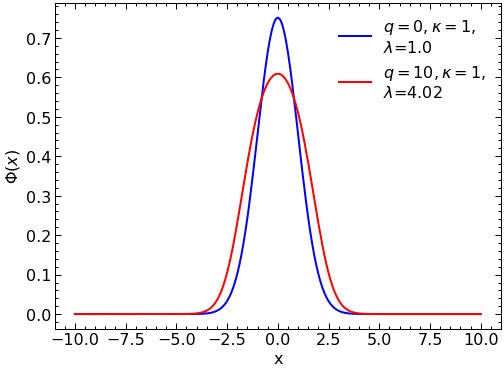

In [5]:


plt.plot(x_array, solution0[1][0], color="blue",label = r'$q=0, \kappa=1,$' "\n" '$\lambda$='+str(round(solution0[0][0],2)))
plt.plot(x_array, abs(solution[1][0]), color="red",label = r'$q=10, \kappa=1,$' "\n" '$\lambda$='+str(round(solution[0][0],2)))
plt.legend(loc='upper right')

plt.ylabel("$\Phi(x)$")
plt.xlabel("x")
plt.show()

## The Reduced Basis Method approach

### Construction of the Reduced Basis

Now we select a set of values of $\alpha$ to solve with the finite element method. These solutions will be used as the basis in the reduced basis model.

In [6]:
# Select alpha values to use to solve SE exactly.
alpha_vals = [[0,1],[1,1],[0,2],[5,1],[10,1]]  #[q,kappa] Here, we choose 5 values of alpha to solve exactly. This results in 3 basis functions
# initialize solution arrays. T is the matrix that will hold wavefunction solutions. 
# T has the form T[i][j], i = alpha, j = solution components
T = np.zeros((len(alpha_vals),m)) 
# T_evals holds the eigenvalues for each evect in T. 
T_evals = np.zeros(len(alpha_vals))

In [7]:
for i,alpha_sample in enumerate(alpha_vals):
    
    evals, evects = IterativeSolver(x_array,alpha_sample[0],alpha_sample[1],700) # solve the system for evals and evects.
    T[i] = evects[n]/np.linalg.norm(evects[n]) # assign the nth evect to solution array T
    T_evals[i] = evals[n] # assign the nth eigenvalue to the eigenvalue array T_eval.
    print(f'alpha = {alpha_sample}, lambda = {round(evals[n],3)}')
    


alpha = [0, 1], lambda = 0.999
alpha = [1, 1], lambda = 1.383
alpha = [0, 2], lambda = 1.413
alpha = [5, 1], lambda = 2.69
alpha = [10, 1], lambda = 4.023


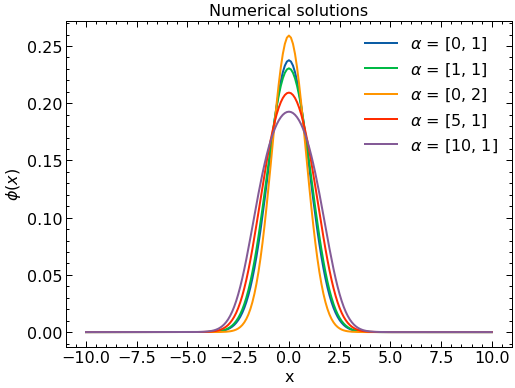

In [8]:
# Make plots of the numerical wavefunctions
# fig, ax = plt.subplots(1,1,figsize=(5,3))
for i in range(len(alpha_vals)):
    
    plt.plot(x_array,(T[i]),label=r'$\alpha$ = '+str(alpha_vals[i]))

plt.title('Numerical solutions')

plt.legend()

plt.ylabel(r'$\phi(x)$')
plt.xlabel("x")

plt.show()

### Proper Orthogonal Decomposition

Follolwing the same procedure as with the Harmonic Oscillator, after obtained a sample of what the solutions look like for some values of the parameters we proceed now to construct our basis with two elements. These elements will be selected as the first two principal components of a [Principal Component Analysis](https://en.wikipedia.org/wiki/Principal_component_analysis) or Proper Orthogonal Decomposition aiming at capturing the two components that can better explain (in a linear way) the variability among our samples. 

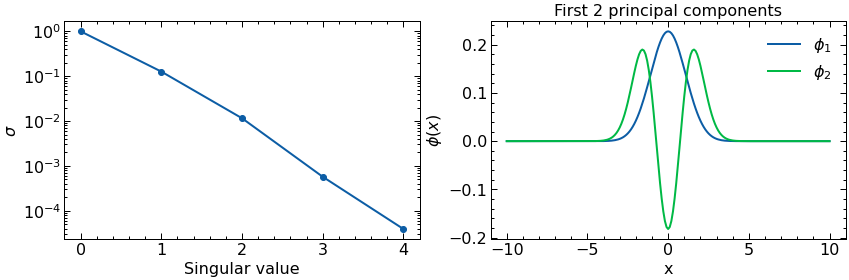

In [9]:
U, s, Vh = np.linalg.svd(T)
phi1=-1*Vh[0] #multiplying by -1 so they are positive at x=0, not necessary but the plots look better
phi2=1*Vh[1]
n_comps = 2 # number of principle components to plot (i.e number of column vectors of SVD matrix V to plot)
fig, ax = plt.subplots(1,2,figsize=(14,4))
ax[0].semilogy(s/s[0],'o-')
ax[0].set_xlabel(r'Singular value')
ax[0].set_ylabel(r'$\sigma$')

ax[1].plot(x_array,phi1,label=r'$\phi_1$')
ax[1].plot(x_array,phi2,label=r'$\phi_2$')
ax[1].set_xlabel(r'x')
ax[1].set_ylabel(r'$\phi(x)$')
ax[1].set_title(f'First {n_comps} principal components')
ax[1].legend()
plt.show()


### Effective two level system "Hamiltonian"

This discussion retraces everything we did before for the Harmonic Oscillator. The main difference is that now the Hamiltonian effectively depends on the solution $H_\alpha \equiv H_\alpha[\phi]$, but since we are aiming at solving the problem iteratively, at each stage we have a fixed linear Hamiltonian.

Here we explicitly construct $ \hat{\phi}_{\alpha}= a_{1} \phi_{1}+a_2\phi_2$ and use the Galerkin method, that is, projecting $F_{\alpha}\big( \hat{\phi}_{\alpha}(x) \big)$ over $2$ linearly independent functions projecting functions $\{ \psi_{i}\}_{i=1}^{2}$. 

\begin{align}
&\langle \psi_{1}| F_{\alpha}\big( \hat{\phi}_{\alpha}(x) \big) \rangle = 0 \\
&\langle \psi_{2}| F_{\alpha}\big( \hat{\phi}_{\alpha}(x) \big) \rangle = 0 
\end{align}

We can interpret this as enforcing the orthogonality of $F_{\alpha}\big( \hat{\phi}_{\alpha}(x) \big)$ to the subspace spanned by $\{\psi_{i}\}$ that is, by finding $\hat{\phi}_{\alpha}$ such that $F_{\alpha}(\hat{\phi}_{\alpha})$ is approximately zero up to the ability of the set $\{\psi_{i}\}$. The choice of projecting functions $\{ \psi_{i} \}$ is arbitrary, but here we choose the solution set $\{ \phi_{i} \}$ to be our projecting functions to make our lives easier. Since $\lambda$ is also unknown, we need an additional equation. This comes from the normalization conditions:

\begin{align}
\langle \hat{\phi}_{\alpha_{k}}|\hat{\phi}_{\alpha_{k}} \rangle  = 1
\end{align}

We can re-write the projecting equations taking advantage of the linear form of $F_\alpha$ to obtain an effective 2-level system Hamiltonian. We note that:

\begin{align}
&\langle \phi_{i}| F_{\alpha}\big( \hat{\phi}_{\alpha}(x) \big) \rangle =  \\
&\langle \phi_{i}|  a_1 H_\alpha \phi_1 + a_2 H_\alpha \phi_2 - a_1\hat \lambda \phi_1 - a_2\hat \lambda \phi_2\rangle
\end{align}

Since $\langle \phi_i|\phi_j\rangle = \delta _{i,j}$, we arrive at the following matrix equation for the projecting equations:

\begin{equation}
\tilde H_\alpha |a\rangle = \hat\lambda |a\rangle
\end{equation}

where $|a\rangle = \{a_1,a_2\}$ and 

\begin{equation}
\tilde H_\alpha = \begin{bmatrix} \langle \phi_1|H_\alpha|\phi_1\rangle & \langle \phi_1|H_\alpha|\phi_2\rangle \\ \langle \phi_2|H_\alpha|\phi_1\rangle & \langle \phi_2|H_\alpha|\phi_2\rangle \end{bmatrix}
\end{equation}

while the normalization condition translates into:

\begin{equation}
\langle a|a \rangle  = a_1^2+a_2^2= 1
\end{equation}


Now we proceed to construct this Hamiltonian matrix for our problem at hand. We note that although $\tilde H_\alpha$ depennds on $\alpha$, the dependance is only in the two potential parts and it is affine (linear): $H_\alpha=H_0+\kappa H_1 +q H_2$, where $H_0= - \frac{d^{2}}{dx^{2}}$, $H_1= x^2$, and $H_2=|\phi(x)|^2$. We then decompose $\tilde H_\alpha= \tilde H_0 + \kappa \tilde H_1+ q \tilde H_2$. We now construct these matrices, $H_2$ being a function that must be constructed every time we wish to iterate the approach.|

In [10]:
dim0 = len(x_array)
off_diag = np.zeros(dim0)
off_diag[1] = 1

H0=-1*(-2*np.identity(dim0) + sci.linalg.toeplitz(off_diag))/(mass*h**2) 
H1=np.diag(V(x_array,1))

tildeH0=np.array([[0.0,0.0],[0.0,0.0]])
tildeH1=np.array([[0.0,0.0],[0.0,0.0]])

tildeH0[0][0]=np.dot(phi1,np.dot(H0,phi1))
tildeH0[0][1]=np.dot(phi1,np.dot(H0,phi2))
tildeH0[1][0]=np.dot(phi2,np.dot(H0,phi1))
tildeH0[1][1]=np.dot(phi2,np.dot(H0,phi2))

tildeH1[0][0]=np.dot(phi1,np.dot(H1,phi1))
tildeH1[0][1]=np.dot(phi1,np.dot(H1,phi2))
tildeH1[1][0]=np.dot(phi2,np.dot(H1,phi1))
tildeH1[1][1]=np.dot(phi2,np.dot(H1,phi2))



#In the following we define the pieces needed for H2 tilde

H2_11=np.diag(phi1**2)
H2_12=np.diag(phi1*phi2)
H2_22=np.diag(phi2**2)

tildeH2_11=np.array([[0.0,0.0],[0.0,0.0]])
tildeH2_11[0][0]=np.dot(phi1,np.dot(H2_11,phi1))
tildeH2_11[0][1]=np.dot(phi1,np.dot(H2_11,phi2))
tildeH2_11[1][0]=np.dot(phi2,np.dot(H2_11,phi1))
tildeH2_11[1][1]=np.dot(phi2,np.dot(H2_11,phi2))




tildeH2_12=np.array([[0.0,0.0],[0.0,0.0]])
tildeH2_12[0][0]=np.dot(phi1,np.dot(H2_12,phi1))
tildeH2_12[0][1]=np.dot(phi1,np.dot(H2_12,phi2))
tildeH2_12[1][0]=np.dot(phi2,np.dot(H2_12,phi1))
tildeH2_12[1][1]=np.dot(phi2,np.dot(H2_12,phi2))


tildeH2_22=np.array([[0.0,0.0],[0.0,0.0]])
tildeH2_22[0][0]=np.dot(phi1,np.dot(H2_22,phi1))
tildeH2_22[0][1]=np.dot(phi1,np.dot(H2_22,phi2))
tildeH2_22[1][0]=np.dot(phi2,np.dot(H2_22,phi1))
tildeH2_22[1][1]=np.dot(phi2,np.dot(H2_22,phi2))

def tildeH2(coeffs):
    
    return (coeffs[0]**2*tildeH2_11+2*coeffs[0]*coeffs[1]*tildeH2_12+coeffs[1]**2*tildeH2_22)/h
    


We print the effective Hamiltonian parts for some sets of parameters just as a sanity check

In [11]:
print('H0=', tildeH0)
print('H1=',tildeH1)

print('H2=',tildeH2([1,0]))


H0= [[ 0.42023097 -0.58365092]
 [-0.58365092  2.61560759]]
H1= [[0.59436083 0.82835933]
 [0.82835933 2.3627665 ]]
H2= [[ 0.36584365 -0.13715205]
 [-0.13715205  0.16958109]]


Now we are ready to create the iterative solver (in the Reduced Basis space!)

In [12]:
def tildeH(alpha,coeffs):
    return tildeH0+alpha[1]*tildeH1+alpha[0]*tildeH2(coeffs)

def systemSolver(alpha,coeffs):
    resultssystem= np.linalg.eig(tildeH(alpha,coeffs))
    # if resultssystem[1][0][0]<0:
    #     resultssystem[1][0]=resultssystem[1][0]*(-1)
    # if resultssystem[1][1][0]<0:
    #     resultssystem[1][1]=resultssystem[1][1]*(-1)   
    return [resultssystem[0],np.transpose(resultssystem[1])]

def phibuilderFromCoeffs(coefficients):
    coefficients0=[coefficients[0]/(np.linalg.norm(coefficients))/np.sqrt(h),coefficients[1]/(np.linalg.norm(coefficients))/np.sqrt(h)]
    return coefficients0[0]*phi1+coefficients0[1]*phi2

def IterativeRBMsolver(alpha,maxIterations):
    sol0=systemSolver([0,alpha[1]],[1,0])
       
    ListOfPhiOlds=[np.copy(sol0[1][0]),np.copy(sol0[1][0]),np.copy(sol0[1][0]),np.copy(sol0[1][0]),np.copy(sol0[1][0]),np.copy(sol0[1][0])]
    for IJ in range(maxIterations):
        #We start building the interaction term adiabatically, so as not to scare the system too much
        if IJ<maxIterations/2:
            qeff=alpha[0]*(IJ/maxIterations)*2
        else:
            qeff=alpha[0]
        #As before, we use an average of the terms for the potential to avoid oscillations
        sol0=systemSolver([qeff,alpha[1]],  
        (ListOfPhiOlds[-1]+ListOfPhiOlds[-2]+ListOfPhiOlds[-3]+ListOfPhiOlds[-4]+ListOfPhiOlds[-5]+ListOfPhiOlds[-6])/6.0
        )


        ListOfPhiOlds.append(np.copy(sol0[1][0]))
    return sol0


Now we try our solution solver against the finite element computation:

In [13]:
alpha_k = [7,1]



st = time.time()
solFiniteFull=IterativeSolver(x_array,alpha_k[0],alpha_k[1],700)
et = time.time()
elapsed_timeFinite = et - st

solFinite=solFiniteFull[1][0]
lamFinite=solFiniteFull[0][0]



st = time.time()
solFull=IterativeRBMsolver(alpha_k,700)
et = time.time()
elapsed_timeRB = et - st

solGaler=phibuilderFromCoeffs(solFull[1][0])
lamGaler=solFull[0][0]




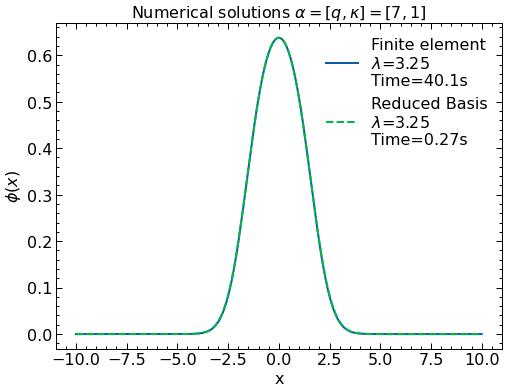

Computational speed gain=  148.9


In [14]:
# Make plots of the numerical wavefunctions
fig, ax = plt.subplots(1,1)


ax.plot(x_array,solFinite,label=r'Finite element'"\n" '$\lambda$='+str(round(lamFinite,2)) + "\n" 'Time='+str(round(elapsed_timeFinite,1)) + 's'  )


ax.plot(x_array,-solGaler,label= r'Reduced Basis'"\n" '$\lambda$='+str(round(lamGaler,2))+ "\n" 'Time='+str(round(elapsed_timeRB,2)) + 's' ,linestyle='dashed')



ax.set_title('Numerical solutions ' r'$\alpha=[q,\kappa]=[7,1]$')
plt.ylabel(r'$\phi(x)$')
plt.xlabel("x")
ax.legend()

plt.show()
print("Computational speed gain= ",round(elapsed_timeFinite/elapsed_timeRB,1))

Interestingly enough, not only the Reduced Basis reproduces the wave function and energy perfectly, it does so almost 200 times faster than the original finite element computation (hurray for reduced basis methods!).

## Quantum Computing on the Reduced Basis

Now that we've laid the groundwork for getting RBM solutions for this nonlinear problem, we can explore how to get it running in the quantum paradigm. The next cell will contain a lot of setup without much explanation, so it's recommended that you check back in the VQE, noise, and RBM sections for individual explanations.

In [15]:


def pauli_token_to_operator(token):
    qubit_terms = []

    for term in range(len(token)):
        # Special case of identity
        if token[term] == "I":
            pass
        else:
            #pauli, qubit_idx = term, term
            if token[term] == "X":
                qubit_terms.append(qml.PauliX(int(term)))
            elif token[term] == "Y":
                qubit_terms.append(qml.PauliY(int(term)))
            elif token[term] == "Z":
                qubit_terms.append(qml.PauliZ(int(term)))
            else:
                print("Invalid input.")
    if(qubit_terms==[]):
            qubit_terms.append(qml.Identity(0))
    full_term = qubit_terms[0]
    for term in qubit_terms[1:]:
        full_term = full_term @ term

    return full_term


def parse_hamiltonian_input(input_data):
    # Get the input
    coeffs = []
    pauli_terms = []
    chunks = input_data.split("\n")
    # Go through line by line and build up the Hamiltonian
    for line in chunks:
        #line = line.strip()
        tokens = line.split(" ")
        # Parse coefficients
        sign, value = tokens[0][0], tokens[1]

        coeff = float(value)
        if sign == "-":
            coeff *= -1
        coeffs.append(coeff)

        # Parse Pauli component
        pauli = tokens[3]
        
        pauli_terms.append(pauli_token_to_operator(pauli))

    return qml.Hamiltonian(coeffs, pauli_terms)

def ham(N,mat_ele,mapper=JordanWignerMapper):
    # Start out by zeroing what will be our fermionic operator
    op = 0
    for i in range(N):
        for j in range(N):
            # Construct the terms of the Hamiltonian in terms of creation/annihilation operators 
            op +=  float(mat_ele[i][j]) * \
            FermionicOp([([("+", i),("-", j)], 1.0)])

    hamstr = "+ "+str(mapper().map(second_q_op=op))

    hamiltonian = parse_hamiltonian_input(hamstr)

    return hamiltonian 

We'll define functions to help with running VQE since we will likely need to do it a few times.

`update_ham` will return an updated hamiltonian given basis coefficients and the alpha vector

`run_vqe_fixed` will run the VQE algorithm for a fixed hamiltonian defined by input coefficients

`run_vqe` performs VQE with a dynamically updating Hamiltonian during the gradient descent. This algorithm decreases the total number of iterations required for convergence at the cost of additional measurements per step -- but it tends towards being much more efficient.

In [16]:
def update_ham(alpha,coeffs):
    # Define dimension
    dim = len(coeffs)

    # Define Hamiltonian
    mat_ele = tildeH(alpha,coeffs)

    H = ham(dim, mat_ele)
    return H

def run_vqe_fixed(alpha, coeffs, init_params, dev, max_iter=500, conv_tol=1e-6, step_size=0.1, debug=False):

    H = update_ham(alpha,coeffs)

    cost_fn = qml.ExpvalCost(ansatz, H, dev)
    
    opt = qml.GradientDescentOptimizer(stepsize=step_size)

    params = init_params

    gd_param_history = [params]
    gd_cost_history = []

    start = time.time()

    for n in range(max_iter):
        # Take a step in parameter space and record your energy
        params, prev_energy = opt.step_and_cost(cost_fn, params)

        # This keeps track of our energy for plotting at comparisons
        gd_param_history.append(params)
        gd_cost_history.append(prev_energy)

        # Here we see what the energy of our system is with the new parameters
        energy = cost_fn(params)

        # Calculate difference between new and old energies
        conv = np.abs(energy - prev_energy)

        end = time.time()

        if (n % 1 == 0) and debug:
            print(
                "It = {:},  Energy = {:.8f},  Conv = {"
                ":.8f}, Time Elapsed = {:.3f} s".format(n, energy, conv,end-start)
            )
            start = time.time()


        if conv <= conv_tol:
            break

    if(debug): print("Final value of the energy = {:.8f}".format(energy))
    if(debug): print("Number of iterations = ", n)

    return params, energy, n, gd_cost_history

def run_vqe(alpha, coeffs, init_params, dev, mixing=0.5, max_iter=500, \
    noisy=False, conv_tol=1e-6, step_size=0.1, debug=False):
    if(noisy):
        prob_circ = noisy_prob_circuit
    else:
        prob_circ = prob_circuit

    H = update_ham(alpha,coeffs)

    cost_fn = qml.ExpvalCost(ansatz, H, dev)
    
    opt = qml.GradientDescentOptimizer(stepsize=step_size)

    params = init_params

    probs = prob_circ(params)
    new_coeffs = np.sqrt(probs[1:3])

    gd_param_history = [params]
    gd_cost_history = []

    start = time.time()
    energy = 10.0
    for n in range(max_iter):
        # Take a step in parameter space and record your energy
        params, prev_energy = opt.step_and_cost(cost_fn, params)
        prev_energy = energy
        # This keeps track of our energy for plotting at comparisons
        gd_param_history.append(params)
        gd_cost_history.append(prev_energy)

        # Here we see what the energy of our system is with the new parameters
        energy = cost_fn(params)

        # Calculate difference between new and old energies
        conv = np.abs(energy - prev_energy)

        # Update hamiltonian with new coeffs
        probs = prob_circ(params)
        new_coeffs = np.sqrt(probs[1:3])
        coeffs = (1.0-mixing)*coeffs + mixing*new_coeffs

        H = update_ham(alpha,coeffs)

        cost_fn = qml.ExpvalCost(ansatz, H, dev)

        end = time.time()

        if (n % 1 == 0) and debug:
            print(
                "It = {:},  Energy = {:.8f},  Conv = {"
                ":.8f}, Time Elapsed = {:.3f} s".format(n, energy, conv,end-start)
            )
            start = time.time()


        if conv <= conv_tol:
            break

    if(debug): print("Final value of the energy = {:.8f}".format(energy))
    if(debug): print("Number of iterations = ", n)

    return params, energy, n, gd_cost_history



Up next is setting up our circuits! This is exactly from the [Quantum Computing RBM](horbm/quantum.ipynb) example since we're not concerning ourselves with noise just yet.

(<Figure size 1300x300 with 1 Axes>, <Axes:>)


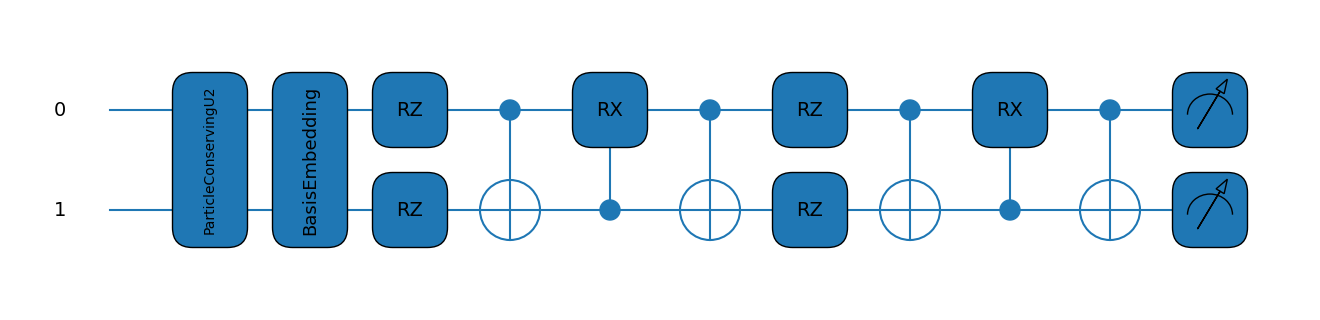

In [28]:
# Set the order you'd like to go to

dim = 2

# Setup the device. Here we'll use the default qubit just to get it working
dev = qml.device("default.qubit", wires=dim)

# Define a general ansatz for arbitrary numbers of dimensions

particles = 1

ref_state = qml.qchem.hf_state(particles, dim)

ansatz = partial(qml.ParticleConservingU2, init_state=ref_state)

layers = dim

# generate the prob function
@qml.qnode(dev)
def prob_circuit(params):
    ansatz(params, wires=dev.wires)
    return qml.probs(wires=dev.wires)

Now let's see what happens when running VQE for only the first element in the basis.

In [40]:
init_params = np.random.uniform(low=-np.pi / 2, high=np.pi / 2, size=qml.ParticleConservingU2.shape(n_layers=layers, n_wires=dim))

update_ham(alpha_k,[1,0])

classical=np.linalg.eig(tildeH(alpha_k,[1,0]))
print("Result expected from classical computation: ", classical[0][0])
params, energy, n, _ = run_vqe_fixed(alpha_k,np.array([1,0]),init_params,dev)
print("Result from VQE: ",energy)

Result expected from classical computation:  3.391048364894118
Result from VQE:  3.391049270960056


Awesome! With our basis coefficients set to `[1,0]`, we get the same result as we expect from before. Now comes the fun part of iteratively solving the problem! There are two approaches we could take:

- "Standard" Iterative VQE | This method is the simplest conceptually and closely tracks the methods used to iteratively solve the problem on classical systems - namely you use the VQE to solve the optimal parameters for a fixed initial Hamiltonian, then you compute the coefficients of the basis and do it again. Between VQE runs you can mix the coefficients to ensure convergence, but ultimately you will obtain the optimal parameters and coefficients for the problem.

- "Dynamic" VQE | This method performs a measurement to determine the coefficients every step within the VQE algorithm and dynamically updates the Hamiltonian. This leads to faster convergence for this nonlinear problem and fewer steps overall.

We have implemented both methods in the notebook, and show both in the following cells. Feel free to play around with the parameters that tune the VQE algorithm and see what the effects are!

In [41]:
debug=False
classical=IterativeRBMsolver(alpha_k,1000)

sol_params, energy, n, _ = run_vqe_fixed(alpha_k,[1,0],init_params,dev)
probs = prob_circuit(sol_params)
new_coeffs = np.sqrt(probs[1:3])
coeffs = new_coeffs
if(debug): print("Coefficients: ",coeffs)

mixing = 0.5

total_it = n
prev_energy = 10.0
for i in range(200):
    coeffs = (1.0-mixing)*coeffs + mixing*new_coeffs
    sol_params, energy, n, _ = run_vqe_fixed(alpha_k,coeffs,sol_params,dev)
    total_it += n
    if(abs(energy-prev_energy) < 1e-6):
        print("Convergence tolerance met!")
        break
    prev_energy = energy
    probs = prob_circuit(sol_params)
    new_coeffs = np.sqrt(probs[1:3])
    if(debug): print("Coefficients: ",coeffs)

print("Result from classical computation: ", classical[0][0])
print("Coefficients from classical computation: ",-classical[1][0][0],-classical[1][0][1])
print("Result from standard VQE: ",energy)
print("Coefficients from standard VQE: ",new_coeffs[0],new_coeffs[1])
print("Total Iterations Required: ", total_it)


Convergence tolerance met!
Result from classical computation:  3.250220285551576
Coefficients from classical computation:  0.9913354984896011 0.13135421361484464
Result from standard VQE:  3.2502193216050816
Coefficients from standard VQE:  0.9913354828795378 0.13135433142456146
Total Iterations Required:  68


In [42]:
sol_params, energy, n, _ = run_vqe(alpha_k,np.array([1,0]),init_params,dev)

probs = prob_circuit(sol_params)
coeffs = np.sqrt(probs[1:3])
print("Result from classical computation: ", classical[0][0])
print("Coefficients from classical computation: ",-classical[1][0][0],-classical[1][0][1])
print("Result from dynamic VQE: ",energy)
print("Coefficients from dynamic VQE: ",coeffs[0],coeffs[1])
print("Total Iterations Required: ", n)

Result from classical computation:  3.250220285551576
Coefficients from classical computation:  0.9913354984896011 0.13135421361484464
Result from dynamic VQE:  3.2502198387574284
Coefficients from dynamic VQE:  0.9913355015975414 0.13135419015909147
Total Iterations Required:  23


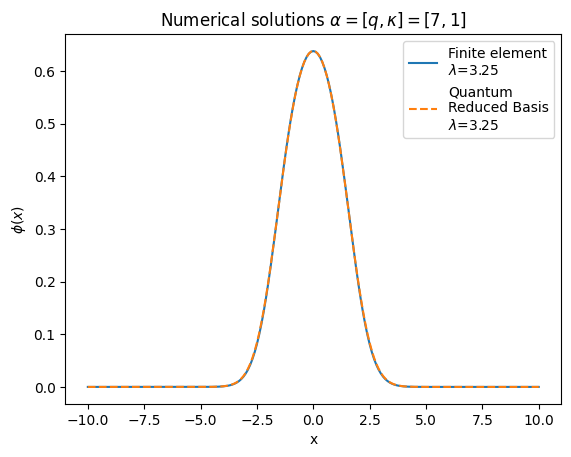

In [43]:

solGaler=phibuilderFromCoeffs(coeffs)
lamGaler=solFull[0][0]

# Make plots of the numerical wavefunction 
fig, ax = plt.subplots(1,1)

ax.plot(x_array,solFinite,label=r'Finite element'"\n" '$\lambda$='+str(round(lamFinite,2)))
ax.plot(x_array,solGaler,label= r'Quantum' "\n" 'Reduced Basis'"\n" '$\lambda$='+str(round(lamGaler,2)),linestyle='dashed')

ax.set_title('Numerical solutions ' r'$\alpha=[q,\kappa]=[7,1]$')
plt.ylabel(r'$\phi(x)$')
plt.xlabel("x")
ax.legend()

plt.show()







They both perform really well, but the dynamic VQE requires less messy code to get it running, so that's what we'll use next! What we'll do now is add some noise to our circuit and see how that affects our performance.

In [44]:
#define some noise model to use in pennylane from qiskit.test.mock
from qiskit.test.mock import FakeLima
from qiskit.providers.aer.noise import NoiseModel
import mitiq as mq
from mitiq.zne.scaling import fold_global
from mitiq.zne.inference import RichardsonFactory
from pennylane.transforms import mitigate_with_zne

backend = FakeLima()
noise_model = NoiseModel.from_backend(backend)

#set up noisy device
dev_sim = qml.device("qiskit.aer", wires=2, noise_model=noise_model, optimization_level=0, shots=10000)

# generate the prob function
@qml.qnode(dev_sim)
def noisy_prob_circuit(params):
    ansatz(params, wires=dev_sim.wires)
    return qml.probs(wires=dev_sim.wires)

sol_params, energy, n, energy_history = run_vqe(alpha_k,np.array([1,0]),init_params,dev_sim,\
    max_iter=20,debug=False,noisy=True)

probs = noisy_prob_circuit(sol_params)
coeffs = np.sqrt(probs[1:3])

print("Result expected from classical computation: ", classical[0][0])
print("Coefficients expected from classical computation: ",-classical[1][0][0],-classical[1][0][1])
print("Result from noisy VQE: ",energy)
print("Coefficients from noisy VQE: ",coeffs[0],coeffs[1])
print("Total Iterations Required: ", n)

Result expected from classical computation:  3.250220285551576
Coefficients expected from classical computation:  0.9913354984896011 0.13135421361484464
Result from noisy VQE:  3.0800371851346857
Coefficients from noisy VQE:  0.9394679345246436 0.17175564037317667
Total Iterations Required:  19


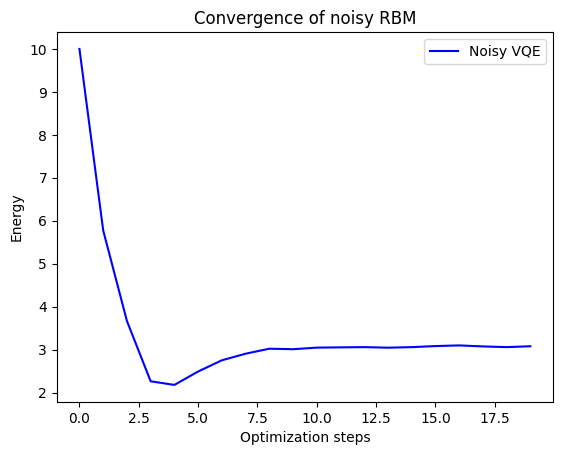

In [45]:
plt.plot(energy_history, "b", label="Noisy VQE")

plt.ylabel("Energy")
plt.xlabel("Optimization steps")
plt.title("Convergence of noisy RBM")
plt.legend()
plt.show()

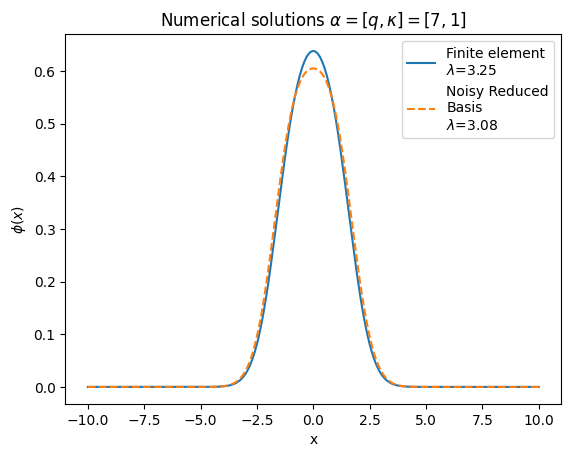

In [46]:
solGaler=phibuilderFromCoeffs(coeffs)
lamGaler=energy

# Make plots of the numerical wavefunction 
fig, ax = plt.subplots(1,1)

ax.plot(x_array,solFinite,label=r'Finite element'"\n" '$\lambda$='+str(round(lamFinite,2)))
ax.plot(x_array,solGaler,label= r'Noisy Reduced' "\n" 'Basis'"\n" '$\lambda$='+str(round(lamGaler,2)),linestyle='dashed')



ax.set_title('Numerical solutions ' r'$\alpha=[q,\kappa]=[7,1]$')
plt.ylabel(r'$\phi(x)$')
plt.xlabel("x")
ax.legend(loc="upper right")

plt.show()




Even with a noisy circuit it doesn't do terribly! It's likely we let it run a little too long, in fact, as our standard convergence criteria isn't well suited to a noisy system. Can you think of any ways to better measure convergence in these cases? Give it a try!

One last thing we can do to get slightly better performance is to leverage zero-noise extrapolation for the coefficients and see if there is a noticeable improvement.

To achieve this we'll first define an extrapolation function to parse the output from our probability function and setup the error mitigated qnode. Then we can run it with three scale factors and extrapolate our coefficients.

Finally, we'll plot the error mitigated solution and see if this was all worth doing!

In [54]:
def prob_extrapolate(scale_factors, results, **extrapolate_kwargs):
    prob1 = RichardsonFactory.extrapolate(scale_factors,results[:,0,1])
    prob2 = RichardsonFactory.extrapolate(scale_factors,results[:,0,2])
    return np.array([prob1,prob2])

#set up scale factors to use
scale_factors = [1, 2, 3, 4]

sim_qnode = qml.QNode(noisy_prob_circuit, dev_sim)

#use ZNE to mitigate error
mitigated_qnode = mitigate_with_zne(scale_factors, fold_global, prob_extrapolate)(sim_qnode)
zne_result = mitigated_qnode(sol_params,shots=2**14)

mitig_coeffs = np.sqrt(zne_result)

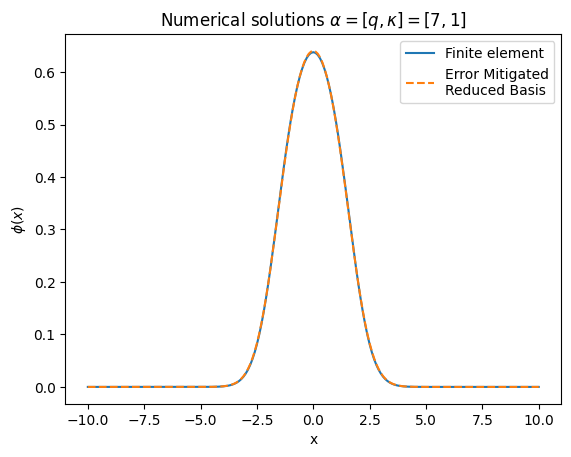

In [55]:
solGaler=phibuilderFromCoeffs(mitig_coeffs)
lamGaler=solFull[0][0]

# Make plots of the numerical wavefunction 
fig, ax = plt.subplots(1,1)

ax.plot(x_array,solFinite,label=r'Finite element')
ax.plot(x_array,solGaler,label= r'Error Mitigated' "\n" 'Reduced Basis',linestyle='dashed')



ax.set_title('Numerical solutions ' r'$\alpha=[q,\kappa]=[7,1]$')
plt.ylabel(r'$\phi(x)$')
plt.xlabel("x")
ax.legend(loc="upper right")


plt.show()

Yet another beautiful result! Compared to the vanilla noisy result a few cells up, this has much better agreement with the 'true' solution provided by the finite element method. And remember, this is the noisy result from a basis of N=2!

I encourage you to try how well we can solve the Gross-Pitaevskii equation with different values of the model parameters, $\alpha = {\kappa,q}$. While we haven't picked something in our basis, it's possible we just got lucky with the values we chose. Indeed, if you vary the parameters well outside the true solutions that inform the basis, you might start to see big deviations. But these deviations will manifest in the classical computing calculations too, so it's not a computational limit but an informational one.

If you want one final challenge, you can try running this on real hardware! The required cell is below, but be warned, this will take a long time to run. You may want to instead use the qiskit VQE runner that we used in the [noise chapter](hardware/ibm.ipynb), as this gets priority when running and had built in mitigation. The only thing you'll need to add is your API token in `token` and choose which machine you want to submit to - a good strategy is finding which one has the lightest queue.

Other than that last charge, this brings us to the end of the final challenge problem for our expansive tutorial series on quantum computing applications to many-body problems. The authors had a great time putting this all together, so we hope you enjoyed going through it :). Come meet our final thoughts and the thanks we want to give to key people in the next and final section of Conclusions and Acknowledgements.

In [ ]:
token = "XXX"

dev_ibm = qml.device('qiskit.ibmq', wires=2, backend='ibm_nairobi', ibmqx_token=token)

init_params = np.array([0.6,])

def ansatz(params, wires):
    t0 = params[0]
    qml.PauliX(wires=0)
    qml.RY(t0, wires=1)
    qml.CNOT(wires=[1,0])


# generate the prob function
@qml.qnode(dev_ibm)
def noisy_prob_circuit(params):
    ansatz(params, wires=dev_ibm.wires)
    return qml.probs(wires=dev_ibm.wires)

sol_params, energy, n, energy_history = run_vqe(alpha_k,np.array([1,0]),init_params,dev_ibm,\
    max_iter=10,debug=True,noisy=True)

probs = noisy_prob_circuit(sol_params)
coeffs = np.sqrt(probs[1:3])

print("Result expected from classical computation: ", classical[0][0])
print("Coefficients expected from classical computation: ",-classical[1][0][0],-classical[1][0][1])
print("Result from noisy VQE: ",energy)
print("Coefficients from noisy VQE: ",coeffs[0],coeffs[1])
print("Total Iterations Required: ", n)